 ***<p style = 'font-size: 70px ;text-align: center'><b>Next Word Prediction</b></p>***
 
 <p style = 'font-size: 20px ;'><b>Made by :- </b></p>
 <p style = 'font-size: 23px ;'>Srivatsa G </p>

---
# Introduction

Next Word Prediction (also called Language Modeling) is the task of predicting what word comes next. It is one of the fundamental tasks of NLP.

Image reference: https://medium.com/@antonio.lopardo/the-basics-of-language-modeling-1c8832f21079

---

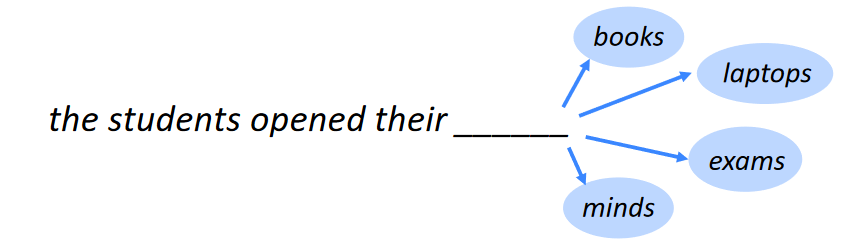

---
## Application Language Modelling

1) Mobile keyboard text recommandation

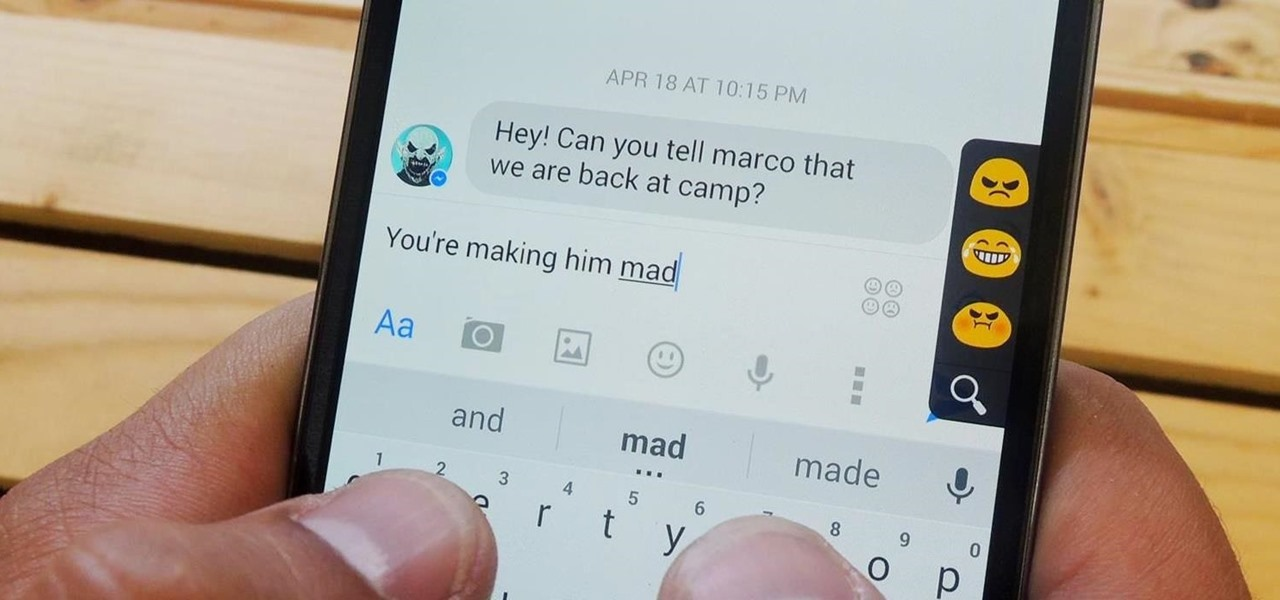

2) Whenever we search for something on any search engine, we get many suggestions and, as we type new words in it, we get better recommendations according to our searching context. So, how will it happen??? 

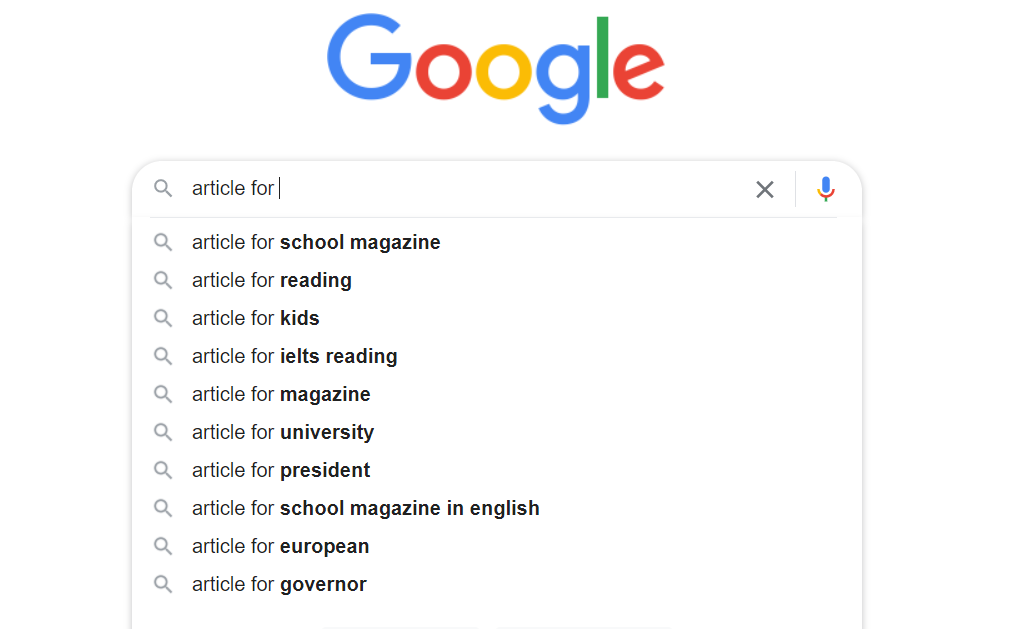

It is poosible through natural language processing (NLP) technique. Here, we will use NLP and try to make a prediction model using Bidirectional LSTM (Long short-term memory) model that will predict next words of sentence.


---

### More about the dataset , check 

https://www.kaggle.com/datasets/dorianlazar/medium-articles-dataset
### About the program :

https://www.kaggle.com/code/ysthehurricane/next-word-prediction-bi-lstm-tutorial-easy-way

---

## Import necessary libraries and packages

In [2]:
import numpy as np  # Using for different problems related to numericals operations
import pandas as pd  # Using to the read the csv dataset
import tensorflow as tf
from colorama import Back, Fore
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from termcolor import colored, cprint



## Dataset information¶
---
Import Medium-articles-dataset:

This dataset contains information about randomly chosen medium articles published in 2019 from these 7 publications:

    Towards Data Science
    UX Collective
    The Startup
    The Writing Cooperative
    Data Driven Investor
    Better Humans
    Better Marketing



In [2]:
df = pd.read_csv("medium_data.csv")
df.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


### Checking the shape of the dataset

In [3]:
print("Number of records: ", df.shape[0])
print("Number of fields: ", df.shape[1])

Number of records:  6508
Number of fields:  10


---
Here, we have a 10 different fields and 6508 records but we will only use title field for predicting next word.

Display titles of various articles and preprocess them

In [4]:
df["title"]

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

Checking of any Null values

In [5]:
df["title"].isna().sum()

0

---

## Removing unwanted characters and words in titles

Looking at titles, we can see there are some of unwanted characters and words in it which can not be useful for us to predict infact it might decrease our model accuracy so we have to remove it.

In [6]:
df["title"] = df["title"].apply(lambda x: x.replace("\xa0", " "))
df["title"] = df["title"].apply(lambda x: x.replace("\u200a", " "))

In [7]:
df["title"]

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

---

## Tokenzation

Tokenzaion is the process in which we provide an unique id to all the words and make a word index or we can say vocabulary.


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [9]:
tokenizer = Tokenizer(
    oov_token="<oov>"
)  # For those words which are not found in word_index
tokenizer.fit_on_texts(df["title"])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index["<oov>"])
print("Strong: ", tokenizer.word_index["strong"])
print("And: ", tokenizer.word_index["and"])
print("Consumption: ", tokenizer.word_index["consumption"])
print("------------")
print("Example how the data is stored :-\n", list(tokenizer.word_index.items())[:5])

Total number of words:  8238
Word: ID
------------
<oov>:  1
Strong:  4
And:  8
Consumption:  8237
------------
Example how the data is stored :-
 [('<oov>', 1), ('to', 2), ('the', 3), ('strong', 4), ('a', 5)]


---

## Titles text into sequences and make n_gram model

suppose, we have sentence like "I am Yash" and this will convert into a sequence with their respective tokens {'I': 1,'am': 2,'Yash': 3}. Thus, output will be [ '1' ,'2' ,'3' ]

Likewise, our all titles will be converted into sequences.

Then, we will make a n_gram model for good prediction.

Below image explain about everything.

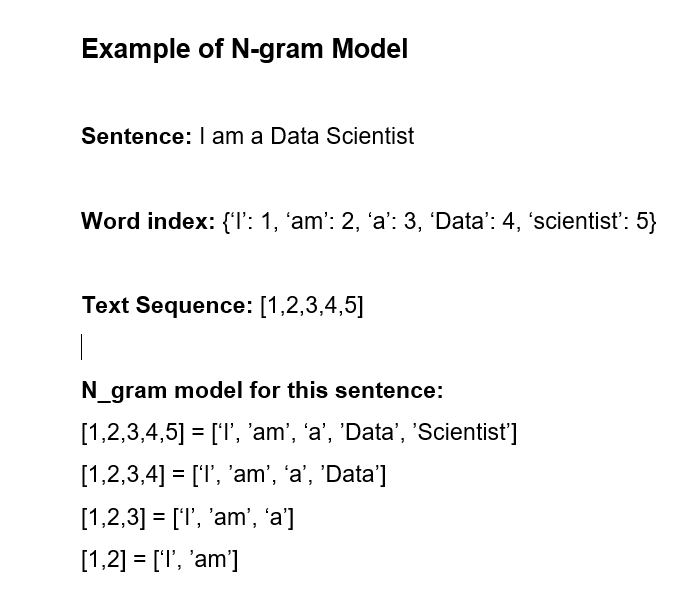

In [19]:
token_list

[7, 2, 65, 5, 85, 56, 730, 550]

In [88]:
input_sequences = []
for line in df["title"]:
    token_list = tokenizer.texts_to_sequences([line])[0]
    # print(token_list)

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[: i + 1]
        input_sequences.append(n_gram_sequence)

print("This is What token list looks like :-", token_list)
cprint("------------", "yellow")
# print(input_sequences)
print("Total input sequences: ", len(input_sequences))
cprint("------------", "yellow")
print(list(tokenizer.word_index.items())[4])
print(list(tokenizer.word_index.items())[675])
print(list(tokenizer.word_index.items())[67])
print(list(tokenizer.word_index.items())[1])
print(list(tokenizer.word_index.items())[451])
print(list(tokenizer.word_index.items())[1517])
cprint("------------", "yellow")
print("This sentence is converted into the below sequence ::")
print(Back.RED, df["title"][0])
# print(len(list(tokenizer.word_index.items())))
input_sequences[:9]

This is What token list looks like :- [7, 2, 65, 5, 85, 56, 730, 550]
------------
Total input sequences:  48461
------------
('a', 5)
('beginner’s', 676)
('guide', 68)
('to', 2)
('word', 452)
('embedding', 1518)
------------
This sentence is converted into the below sequence ::
 A Beginner’s Guide to Word Embedding with Gensim Word2Vec Model


[[5, 676],
 [5, 676, 68],
 [5, 676, 68, 2],
 [5, 676, 68, 2, 452],
 [5, 676, 68, 2, 452, 1518],
 [5, 676, 68, 2, 452, 1518, 14],
 [5, 676, 68, 2, 452, 1518, 14, 2455],
 [5, 676, 68, 2, 452, 1518, 14, 2455, 3653],
 [5, 676, 68, 2, 452, 1518, 14, 2455, 3653, 99]]

In [83]:
import pickle

# saving
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

---

## Make all titles with same length by using padding

The length of every title has to be the same. To make it, we need to find a title that has a maximum length, and based on that length, we have to pad rest of titles.


In [84]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_sequence_len = max([len(x) for x in input_sequences])
# get the maximum length sequence
max_sequence_len

40

In [21]:
input_sequences = np.array(
    pad_sequences(input_sequences, maxlen=max_sequence_len, padding="pre")
)
input_sequences[8]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    5,  676,   68,
          2,  452, 1518,   14, 2455, 3653,   99])

---

## Prepare features and labels

Here, we consider last element of all sequences as a label.Then, We need to perform onehot encoding on labels corresponding to total_words.


In [22]:
input_sequences[:, :]  # This is the original sequences

array([[  0,   0,   0, ...,   0,   5, 676],
       [  0,   0,   0, ...,   5, 676,  68],
       [  0,   0,   0, ..., 676,  68,   2],
       ...,
       [  0,   0,   0, ...,   5,  85,  56],
       [  0,   0,   0, ...,  85,  56, 730],
       [  0,   0,   0, ...,  56, 730, 550]])

In [23]:
input_sequences[:, :-1]  # This is the sequences leaving the last element

array([[  0,   0,   0, ...,   0,   0,   5],
       [  0,   0,   0, ...,   0,   5, 676],
       [  0,   0,   0, ...,   5, 676,  68],
       ...,
       [  0,   0,   0, ...,  65,   5,  85],
       [  0,   0,   0, ...,   5,  85,  56],
       [  0,   0,   0, ...,  85,  56, 730]])

In [24]:
input_sequences[:, -1]  # This is the last element which was omitted

array([676,  68,   2, ...,  56, 730, 550])

In [25]:
xs, labels = input_sequences[:, :-1], input_sequences[:, -1]
print(xs[5])
print(labels[5])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    5  676   68    2  452 1518]
14


In [26]:
cprint("Performing ONE-HOT ENCODING.....", "green")
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)
print("At row-5 and col-14 ==", ys[5][14])
pd.DataFrame(ys).head(6)

Performing ONE-HOT ENCODING.....
At row-5 and col-14 == 1.0


,0,1,2,3,4,5,6,7,8,9,...,8228,8229,8230,8231,8232,8233,8234,8235,8236,8237
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

# **Architechture of Bidirectional LSTM Neural Network**

Long Short-Term Memory (LSTM) networks is an advance recurrent neural network which is apable to store order states by using its cell state feature.

Image reference: https://www.researchgate.net/figure/The-structure-of-the-Long-Short-Term-Memory-LSTM-neural-network-Reproduced-from-Yan_fig8_334268507

Bidirectional LSTM Image reference: https://paperswithcode.com/method/bilstm

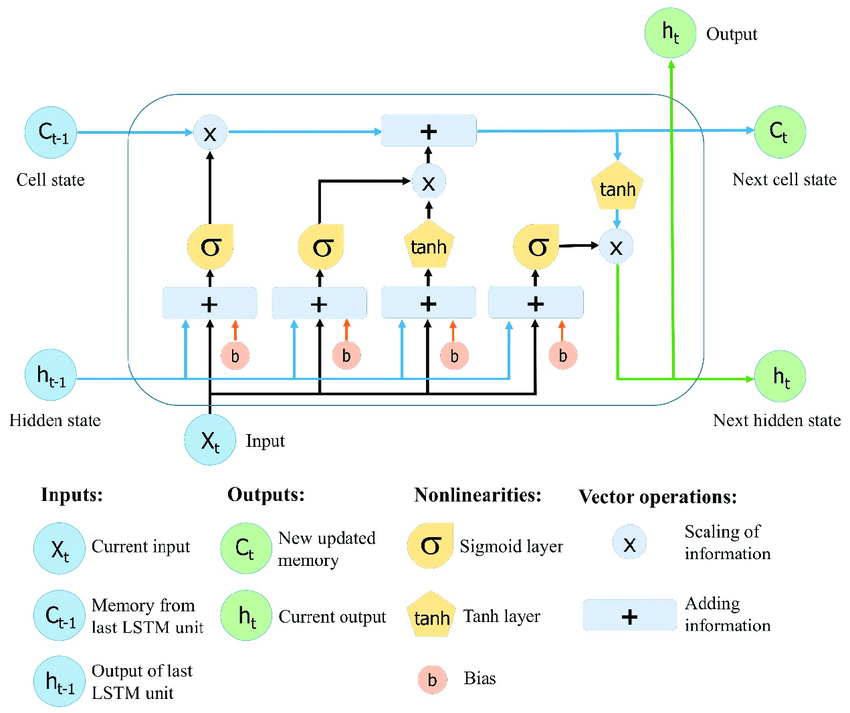

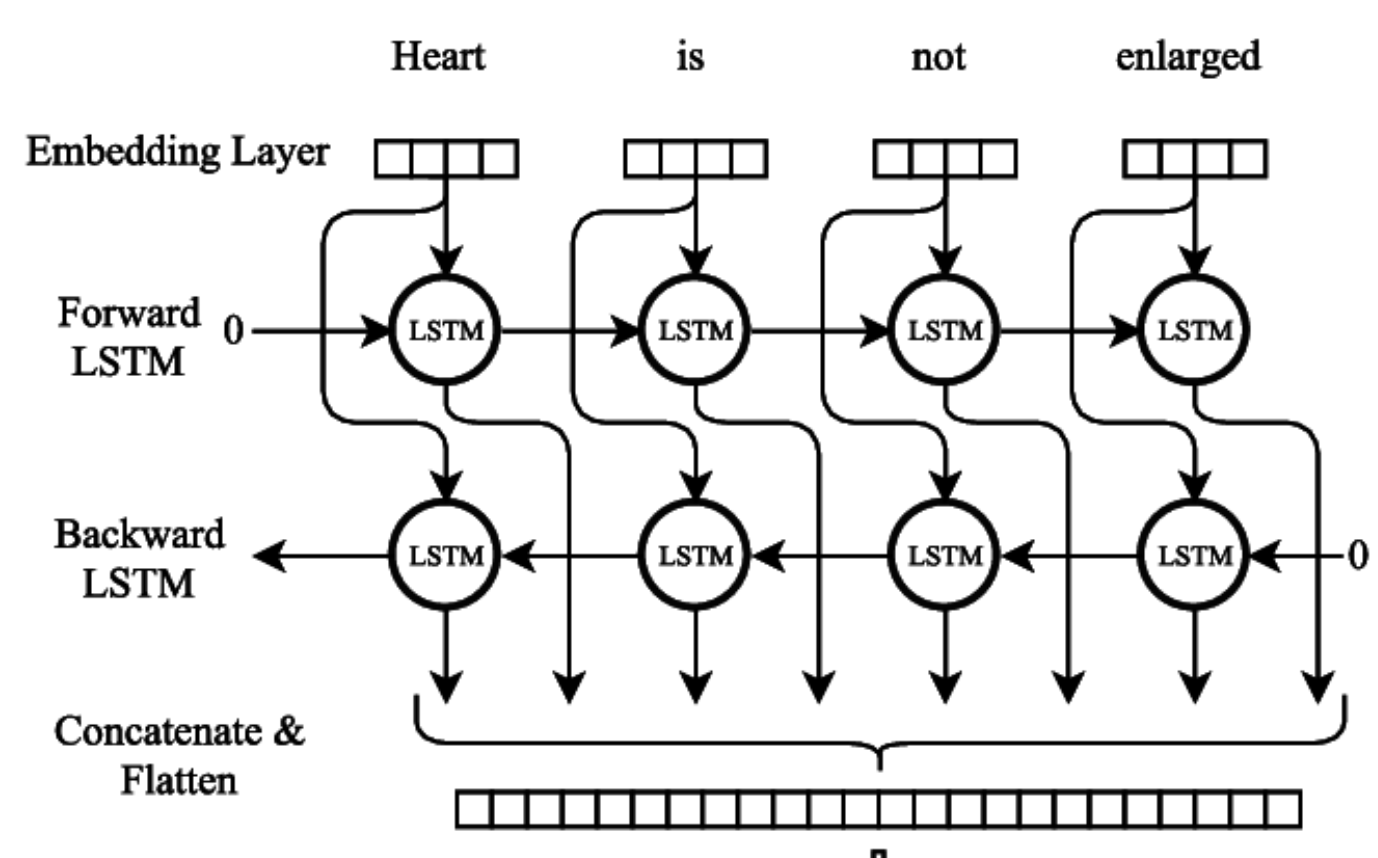

In [27]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len - 1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation="softmax"))
adam = Adam(lr=0.01)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
history = model.fit(xs, ys, epochs=50, verbose=1)
# print model.summary()
print(model)

C:\Users\sriva\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
1515/1515 [==============================] - 45s 16ms/step - loss: 6.9505 - accuracy: 0.1222
Epoch 2/50
1515/1515 [==============================] - 26s 17ms/step - loss: 6.1998 - accuracy: 0.1652
Epoch 3/50
1515/1515 [==============================] - 29s 19ms/step - loss: 4.9790 - accuracy: 0.2004
Epoch 4/50
1515/1515 [==============================] - 30s 20ms/step - loss: 4.2112 - accuracy: 0.2448
Epoch 5/50
1515/1515 [==============================] - 29s 19ms/step - loss: 3.6351 - accuracy: 0.2962
Epoch 6/50
1515/1515 [==============================] - 29s 19ms/step - loss: 3.2361 - accuracy: 0.3411
Epoch 7/50
1515/1515 [==============================] - 29s 19ms/step - loss: 2.9748 - accuracy: 0.3738
Epoch 8/50
1515/1515 [==============================] - 26s 17ms/step - loss: 2.7781 - accuracy: 0.4006
Epoch 9/50
1515/1515 [==============================] - 26s 17ms/step - loss: 2.6418 - accuracy: 0.4225
Epoch 10/50
1515/1515 [==============================] - 26s 17m

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 39, 100)           823800    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              301200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 8238)              2479638   
                                                                 
Total params: 3,604,638
Trainable params: 3,604,638
Non-trainable params: 0
_________________________________________________________________


## Plotting model accuracy and loss

In [61]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

### Graph of Accuracy

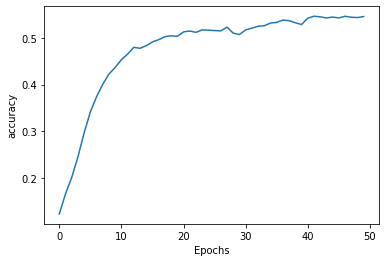

In [62]:
plot_graphs(history, "accuracy")

### Graph of Loss

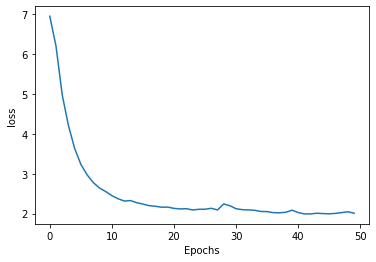

In [33]:
plot_graphs(history, "loss")

In [51]:
def output(text):
    seed_text = text
    next_words = 5

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences(
            [token_list], maxlen=max_sequence_len - 1, padding="pre"
        )
        predicted = np.argmax(model.predict(token_list), axis=-1)
        # model.predict_classes(token_list, verbose=0)
        cprint(predicted, "red")
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)


output("implementation of")

1/1 [==============================] - 0s 34ms/step
[2529]
1/1 [==============================] - 0s 112ms/step
[759]
1/1 [==============================] - 0s 65ms/step
[236]
1/1 [==============================] - 0s 95ms/step
[2657]
1/1 [==============================] - 0s 62ms/step
[344]
implementation of rnn lstm based handwriting recognition


In [92]:
output("python for")

1/1 [==============================] - 0s 38ms/step
[499]
1/1 [==============================] - 0s 47ms/step
[1135]
1/1 [==============================] - 0s 68ms/step
[1487]
1/1 [==============================] - 0s 95ms/step
[158]
1/1 [==============================] - 0s 78ms/step
[2908]
python for beginners cleaning preprocessing web scraped


In [73]:
model.save("my_model.h5")

In [74]:
new_model = tf.keras.models.load_model("my_model.h5")
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 39, 100)           823800    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              301200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 8238)              2479638   
                                                                 
Total params: 3,604,638
Trainable params: 3,604,638
Non-trainable params: 0
_________________________________________________________________


In [86]:
def output_2(text):
    seed_text = text
    next_words = 5

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        print(token_list)
        token_list = pad_sequences(
            [token_list], maxlen=max_sequence_len - 1, padding="pre"
        )

        predicted = np.argmax(new_model.predict(token_list), axis=-1)
        # model.predict_classes(token_list, verbose=0)
        cprint(predicted, "red")
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)


output_2("implementation")

[485]
1/1 [==============================] - 0s 54ms/step
[6]
[485, 6]
1/1 [==============================] - 0s 46ms/step
[2529]
[485, 6, 2529]
1/1 [==============================] - 0s 95ms/step
[759]
[485, 6, 2529, 759]
1/1 [==============================] - 0s 101ms/step
[236]
[485, 6, 2529, 759, 236]
1/1 [==============================] - 0s 84ms/step
[2657]
implementation of rnn lstm based handwriting
